In [9]:
import pandas as pd
from sqlalchemy import create_engine
from tqdm import tqdm
from hurst import compute_Hc


In [2]:
db_connection_str = 'mysql+pymysql://student:SoQ_trading24/25@3.81.230.185/trading'
db_connection = create_engine(db_connection_str)

In [3]:
query = 'SELECT * from trading.futures_1min_bar'
df = pd.read_sql(query, con=db_connection)
print(df.shape)
df.head()

(312823, 8)


,contract,instrument,bid,offer,bid_size,offer_size,timestamp,adjustment
0,ES,ESZ3,4572.75,4573.00,21,31,2023-12-01 00:01:00,316.375
1,ES,ESZ3,4572.50,4572.75,31,23,2023-12-01 00:02:00,316.375
2,ES,ESZ3,4571.75,4572.00,69,20,2023-12-01 00:03:00,316.375
3,ES,ESZ3,4571.75,4572.00,67,21,2023-12-01 00:04:00,316.375
4,ES,ESZ3,4571.75,4572.00,24,47,2023-12-01 00:05:00,316.375


In [6]:
df.to_parquet('data/futures_1min_bar.parquet')

In [ ]:
fx_instrument_sql = "SELECT distinct instrument from trading.fx_1min_bar"
df_fx_instrument = pd.read_sql(fx_instrument_sql, con=db_connection)
fx_list = [fx.replace('"', '') for fx in df_fx_instrument.instrument.values]

In [ ]:
for fx in tqdm(fx_list):
    fx_sql = f"SELECT * from trading.fx_1min_bar where instrument = '\"{fx}\"'"
    df_fx = pd.read_sql(fx_sql, con=db_connection)

    df_fx.to_parquet(f'data/{fx}_data.parquet')

In [4]:
df.groupby(['contract', 'instrument']).agg({'timestamp':['min', 'max']}).reset_index()\
                                                .sort_values(by=('timestamp', 'min'))

contract instrument           timestamp                    
                                      min                 max
4       ES       ESZ3 2023-12-01 00:01:00 2023-12-11 21:59:00
0       ES       ESH4 2023-12-11 22:00:00 2024-03-11 21:00:00
2       ES       ESM4 2024-03-11 21:00:00 2024-06-17 20:57:00
3       ES       ESU4 2024-06-17 21:01:00 2024-09-16 20:59:00
5       ES       ESZ4 2024-09-16 21:00:00 2024-12-16 22:00:00
1       ES       ESH5 2024-12-16 22:00:00 2025-02-24 17:32:00

In [7]:
df = df.sort_values(by='timestamp')
df = df[~df.bid.isna()]
df['Roll Adjusted Bid'] = df['bid'] + df['adjustment']
df['Roll Adjusted Offer'] = df['offer'] + df['adjustment']


df['mid_price'] = (df['Roll Adjusted Bid'] + df['Roll Adjusted Offer']) / 2

# Hurst Exponent

In [18]:
f"SELECT * from trading.fx_1min_bar where instrument = {fx}"

'SELECT * from trading.fx_1min_bar where instrument = "EURCZK"'

['EURCZK',
 'AUDUSD',
 'EURHUF',
 'EURNOK',
 'EURPLN',
 'EURSEK',
 'EURUSD',
 'GBPUSD',
 'NZDUSD',
 'USDCAD',
 'USDCHF',
 'USDCNH',
 'USDILS',
 'USDJPY',
 'USDMXN',
 'USDSGD',
 'USDZAR']

In [27]:
import os

os.getcwd()

'/Users/yuriy/Strategy_project'

In [30]:
df_fx.to_parquet(f'data/ggg{fx}_data.parquet')

In [36]:

fx_list

['EURCZK',
 'AUDUSD',
 'EURHUF',
 'EURNOK',
 'EURPLN',
 'EURSEK',
 'EURUSD',
 'GBPUSD',
 'NZDUSD',
 'USDCAD',
 'USDCHF',
 'USDCNH',
 'USDILS',
 'USDJPY',
 'USDMXN',
 'USDSGD',
 'USDZAR']

100%|██████████| 17/17 [17:51<00:00, 63.05s/it]


In [17]:
# fx_sql = "SELECT distinct instrument from trading.fx_1min_bar"
# df_fx = pd.read_sql(fx_sql, con=db_connection)

for fx in tqdm(df_fx.instrument.values):
    fx_sql = f"SELECT * from trading.fx_1min_bar where instrument = {fx}"
    cur_df_fx = pd.read_sql(fx_sql, con=db_connection)

    cur_df_fx.to_parquet(f'/data/{fx}_data.parquet')
    

  0%|          | 0/17 [00:31<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/data/"EURCZK"_data.parquet'

In [20]:
cur_df_fx

,instrument,bid,offer,timestamp


In [10]:
hurst_value, _, _ = compute_Hc(df['mid_price'], kind='price', simplified=True)
hurst_value

np.float64(0.5243364273932102)

In [87]:
for fx in tqdm(["EURHUF", "EURNOK", "EURSEK"]):
    fx_sql = f"SELECT * from trading.fx_1min_bar where instrument = '\"{fx}\"'"
    df_fx = pd.read_sql(fx_sql, con=db_connection)
    df_fx['mid_price'] = (df_fx['bid'] + df_fx['offer'])/2
    df_fx = df_fx[~df_fx.mid_price.isna()].sort_values(by='timestamp')
    hurst_value, _, _ = compute_Hc(df_fx['mid_price'], kind='price', simplified=True)
    print(fx, hurst_value)

 33%|███▎      | 1/3 [01:23<02:46, 83.25s/it]

EURHUF 0.48428234876796744


 67%|██████▋   | 2/3 [02:49<01:25, 85.18s/it]

EURNOK 0.44138788829907416


100%|██████████| 3/3 [04:17<00:00, 85.89s/it]

EURSEK 0.4448476385508151


# Andrew Lo’s Variance Ratio Test

## a Построить график зависимости Variance Ratio от лага q

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [15:41:34<00:00, 282.47s/it]      


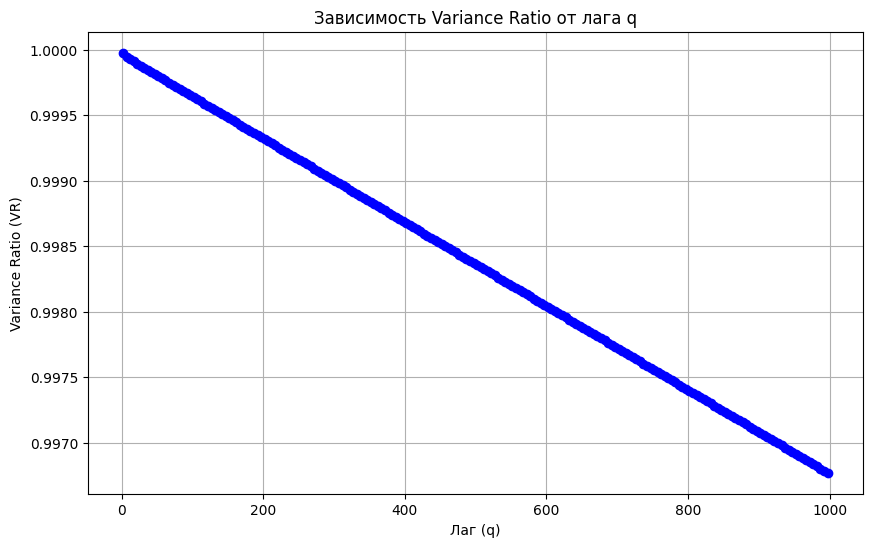

In [95]:
def variance_ratio(df, max_lag, step = 5):
    # Вычисляем доходности
    df['returns'] = df['mid_price'].pct_change().dropna()

    # Рассчитываем Var(1)
    var_1 = np.var(df['returns'])

    # Список для хранения значений VR
    vr_values = []

    # Вычисляем VR(q) для каждого q от 2 до max_lag
    for q in tqdm(range(2, max_lag + 1, step)):
        # Суммируем корреляции для лагов от 1 до q-1
        corr_sum = 0
        for k in range(1, q):
            corr_sum += (1 - k / q) * df['returns'].shift(-k).corr(df['returns'].shift(0))

        # VR(q) = 1 + 2 * сумма
        vr_q = 1 + 2 * corr_sum
        vr_values.append(vr_q)

    return vr_values, range(2, max_lag + 1, step)

    # Строим график Variance Ratio от лага
max_lag = 1000  # максимальный лаг, до которого будем считать VR
vr_values, q_values = variance_ratio(df, max_lag)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(q_values, vr_values, marker='o', linestyle='-', color='b')
plt.title('Зависимость Variance Ratio от лага q')
plt.xlabel('Лаг (q)')
plt.ylabel('Variance Ratio (VR)')
plt.grid(True)
plt.show()
